In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.utils import np_utils
from keras import utils
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

import pywt
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# read the dataset
df_1 = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


y_train = np.array(df_train[187].values).astype(np.int8)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [6]:
# pre-processing for the DBLSTM-WS model
def DWT(signal, levels):
  coeffs = pywt.wavedec(signal.flatten(), 'db6', mode='symmetric', level=levels)[1:]
  coeffs = [np.pad(np.array(c), (0, 187-len(c))) for c in coeffs]
  coeffs += [signal]
  return np.stack(coeffs, axis=-1)

def WSpreprocess(dataset, levels):
  return np.squeeze(np.apply_along_axis(DWT, 1, dataset, levels))

X_train_new = WSpreprocess(np.squeeze(X_train), 2)
X_test_new = WSpreprocess(np.squeeze(X_test), 2)


In [10]:
ensemble_predictions = np.zeros((2911, 2))

path = "/content/drive/MyDrive/MLHC_PROJECT1/H5/PTB/"
import os
for filename in os.listdir(path):
  print(filename)
  model = keras.models.load_model(path + filename)

  if filename == "DBLSTM-WS_ptb.h5":
     y_pred = model.predict(X_test_new)
  else:
    y_pred = model.predict(X_test)

  ensemble_predictions = ensemble_predictions + y_pred

CNN_ptb.h5
transformer_ptb.h5
DBLSTM-WS_ptb.h5
RNN_ptb.h5


In [11]:
y_pred = np.argmax(ensemble_predictions, axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.9820394168561708 
Test accuracy score : 0.9855719683957403 


Model AUROC: 0.9824059492460534


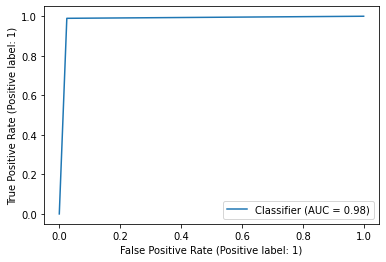

In [14]:
RocCurveDisplay.from_predictions(y_test.reshape(-1,1), y_pred)
print("Model AUROC: {}".format(roc_auc_score(y_test.reshape(-1,1), y_pred, average=None)))

Model AUPRC: 0.9876671865061324


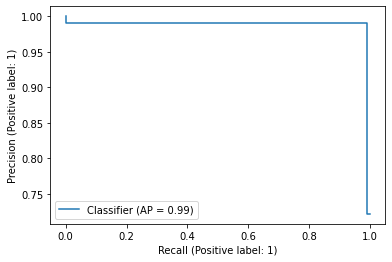

In [16]:
PrecisionRecallDisplay.from_predictions(y_test.reshape(-1,1), y_pred)
print("Model AUPRC: {}".format(average_precision_score(y_test.reshape(-1,1), y_pred)))

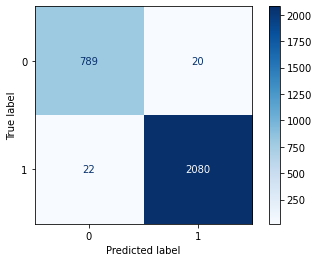

In [12]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()